In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [3]:
!pip install pytorch-crf
!pip install seqeval==1.0.0

     |████████████████████████████████| 14.5MB 235kB/s 
     |████████████████████████████████| 6.8MB 46.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.0.0-cp36-none-any.whl size=14022 sha256=af7601337191f0fe650a8e4d1fd0d060d1327aa01e09b6f6fa563db50a006c24
  Stored in directory: /root/.cache/pip/wheels/9e/82/18/6cfa15bb8d49855b0636bd72d12ab43fe9c4da8e8ba3b94db2
Successfully built seqeval
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-

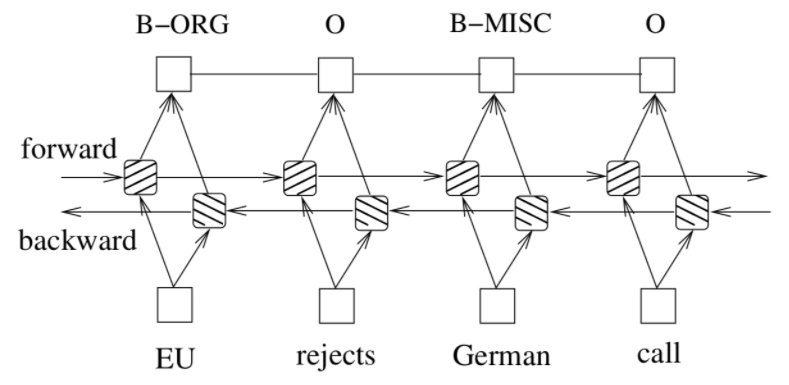

In [8]:
import os
from IPython.display import Image
root_dir = "/gdrive/My Drive/인공지능 실습/해커톤 baseline"
Image(os.path.join(root_dir, "bi_GRU_crfs_model.PNG"))

In [4]:
import torch
import torch.nn as nn
from torchcrf import CRF

from seqeval.metrics import classification_report


class RNN_CRF(nn.Module):
    def __init__(self, config):
        super(RNN_CRF, self).__init__()

        # 전체 음절 개수
        self.eumjeol_vocab_size = config["word_vocab_size"]

        # 음절 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # GRU 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # 분류할 태그의 개수
        self.number_of_tags = config["number_of_tags"]

        # 입력 데이터에 있는 각 음절 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        self.embedding = nn.Embedding(num_embeddings=self.eumjeol_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)

        self.dropout = nn.Dropout(config["dropout"])

        # Bi-GRU layer
        self.bi_gru = nn.GRU(input_size = self.embedding_size,
                             hidden_size= self.hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)

        # CRF layer
        self.crf = CRF(num_tags=self.number_of_tags, batch_first=True)

        # fully_connected layer를 통하여 출력 크기를 number_of_tags에 맞춰줌
        # (batch_size, max_length, hidden_size*2) -> (batch_size, max_length, number_of_tags)
        self.hidden2num_tag = nn.Linear(in_features=self.hidden_size*2, out_features=self.number_of_tags)

    def forward(self, inputs, labels=None):
        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        eumjeol_inputs = self.embedding(inputs)

        encoder_outputs, hidden_states = self.bi_gru(eumjeol_inputs)

        # (batch_size, curr_max_length, hidden_size*2)
        d_hidden_outputs = self.dropout(encoder_outputs)

        # (batch_size, curr_max_length, hidden_size*2) -> (batch_size, curr_max_length, number_of_tags)
        logits = self.hidden2num_tag(d_hidden_outputs)

        if(labels is not None):
            log_likelihood = self.crf(emissions=logits,
                                      tags=labels,
                                      reduction="mean")

            loss = log_likelihood * -1.0

            return loss
        else:
            output = self.crf.decode(emissions=logits)

            return output


In [5]:


from tqdm import tqdm
import numpy as np
# 파라미터로 입력받은 파일에 저장된 단어 리스트를 딕셔너리 형태로 저장
def load_vocab(f_name):
    vocab_file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')
    print("{} vocab file loading...".format(f_name))

    # default 요소가 저장된 딕셔너리 생성
    symbol2idx, idx2symbol = {"<PAD>":0, "<UNK>":1}, {0:"<PAD>", 1:"<UNK>"}

    # 시작 인덱스 번호 저장
    index = len(symbol2idx)
    for line in tqdm(vocab_file.readlines()):
        symbol = line.strip()
        symbol2idx[symbol] = index
        idx2symbol[index]= symbol
        index+=1

    return symbol2idx, idx2symbol

# 입력 데이터를 고정 길이의 벡터로 표현하기 위한 함수
def convert_data2feature(data, symbol2idx, max_length=None):
    # 고정 길이의 0 벡터 생성
    feature = np.zeros(shape=(max_length), dtype=np.int)
    # 입력 문장을 공백 기준으로 split
    words = data.split()

    for idx, word in enumerate(words[:max_length]):
        if word in symbol2idx.keys():
            feature[idx] = symbol2idx[word]
        else:
            feature[idx] = symbol2idx["<UNK>"]
    return feature

# 파라미터로 입력받은 파일로부터 tensor객체 생성
def load_data(config, f_name, word2idx, tag2idx):
    file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')

    # return할 문장/라벨 리스트 생성
    indexing_inputs, indexing_tags = [], []

    print("{} file loading...".format(f_name))

    # 실제 데이터는 아래와 같은 형태를 가짐
    # 문장 \t 태그
    # 세 종 대 왕 은 <SP> 조 선 의 <SP> 4 대 <SP> 왕 이 야 \t B_PS I_PS I_PS I_PS O <SP> B_LC I_LC O <SP> O O <SP> O O O
    for line in tqdm(file.readlines()):
        try:
            id, sentence, tags = line.strip().split('\t')
        except:
            id, sentence = line.strip().split('\t')
        input_sentence = convert_data2feature(sentence, word2idx, config["max_length"])
        indexing_tag = convert_data2feature(tags, tag2idx, config["max_length"])

        indexing_inputs.append(input_sentence)
        indexing_tags.append(indexing_tag)
    indexing_inputs = torch.tensor(indexing_inputs, dtype=torch.long)
    indexing_tags = torch.tensor(indexing_tags, dtype=torch.long)

    return indexing_inputs, indexing_tags

# tensor 객체를 리스트 형으로 바꾸기 위한 함수
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()


In [6]:

from torch.utils.data import (DataLoader, TensorDataset)
import torch.optim as optim

def train(config):
    # 모델 객체 생성
    model = RNN_CRF(config).cuda()
    # 단어 딕셔너리 생성
    word2idx, idx2word = load_vocab(config["word_vocab_file"])
    tag2idx, idx2tag = load_vocab(config["tag_vocab_file"])

    # 데이터 Load
    train_input_features, train_tags = load_data(config, config["train_file"], word2idx, tag2idx)
    test_input_features, test_tags = load_data(config, config["dev_file"], word2idx, tag2idx)

    # 불러온 데이터를 TensorDataset 객체로 변환
    train_features = TensorDataset(train_input_features, train_tags)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    test_features = TensorDataset(test_input_features, test_tags)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=config["batch_size"])

    # 모델을 학습하기위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    accuracy_list = []
    for epoch in range(config["epoch"]):
        model.train()
        losses = []
        for step, batch in enumerate(train_dataloader):
            # .cuda()를 이용하여 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)
            input_features, labels = batch

            # loss 계산
            loss = model.forward(input_features, labels)

            # 변화도 초기화
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            if (step + 1) % 50 == 0:
                print("{} step processed.. current loss : {}".format(step + 1, loss.data.item()))
            losses.append(loss.data.item())



        print("Average Loss : {}".format(np.mean(losses)))

        # 모델 저장
        torch.save(model.state_dict(), os.path.join(config["output_dir_path"], "epoch_{}.pt".format(epoch + 1)))

        do_test(model, test_dataloader, idx2tag)



def test(config):
    # 모델 객체 생성
    model = RNN_CRF(config).cuda()
    # 단어 딕셔너리 생성
    word2idx, idx2word = load_vocab(config["word_vocab_file"])
    tag2idx, idx2tag = load_vocab(config["tag_vocab_file"])


    # 저장된 가중치 Load
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    # 데이터 Load
    test_input_features, test_tags = load_data(config, config["dev_file"], word2idx, tag2idx)

    # 불러온 데이터를 TensorDataset 객체로 변환
    test_features = TensorDataset(test_input_features, test_tags)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=config["batch_size"])
    # 평가 함수 호출
    do_test(model, test_dataloader, idx2tag)

def do_test(model, test_dataloader, idx2tag):
    model.eval()
    predicts, answers = [], []
    for step, batch in enumerate(test_dataloader):
        # .cuda() 함수를 이용하요 메모리에 업로드
        batch = tuple(t.cuda() for t in batch)

        # 데이터를 각 변수에 저장
        input_features, labels = batch

        # 예측 라벨 출력
        output = model(input_features)

        # 성능 평가를 위해 예측 값과 정답 값 리스트에 저장
        for idx, answer in enumerate(tensor2list(labels)):
            answers.extend([idx2tag[e].replace("_", "-") for e in answer if idx2tag[e] != "<SP>" and idx2tag[e] != "<PAD>"])
            predicts.extend([idx2tag[e].replace("_", "-") for i, e in enumerate(output[idx]) if idx2tag[answer[i]] != "<SP>" and idx2tag[answer[i]] != "<PAD>"] )
    
    # 성능 평가
    print(classification_report(answers, predicts))


In [7]:
##########################################################
#                                                        #
#        평가 기준이 되는 지표는 Macro F1 Score          #
#           제출 포맷은 id \t predict_tag                #
#            25 \t B_PS I_PS <SP> O O O ...              #
#                                                        #
##########################################################


import os
if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "train",
              "train_file":"ner_train.txt",
              "dev_file": "ner_dev.txt",
              "word_vocab_file":"vocab.txt",
              "tag_vocab_file":"tag_vocab.txt",
              "trained_model_name":"epoch_{}.pt".format(5),
              "output_dir_path":output_dir,
              "word_vocab_size":2160,
              "number_of_tags": 14,
              "hidden_size": 100,
              "dropout":0.2,
              "embedding_size":100,
              "max_length": 120,
              "batch_size":64,
              "epoch":20,
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)


vocab.txt vocab file loading...


100%|██████████| 2158/2158 [00:00<00:00, 574832.21it/s]


tag_vocab.txt vocab file loading...


100%|██████████| 12/12 [00:00<00:00, 3881.82it/s]


ner_train.txt file loading...


100%|██████████| 7319/7319 [00:00<00:00, 21803.16it/s]


ner_dev.txt file loading...


100%|██████████| 995/995 [00:00<00:00, 23381.72it/s]


50 step processed.. current loss : 17.679113388061523
100 step processed.. current loss : 14.059734344482422
Average Loss : 34.71962947845459
49958
49958


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:45: UserWarning: <PAD> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

          DT       0.59      0.60      0.60       609
          LC       0.60      0.41      0.49       534
          OG       0.47      0.23      0.31       963
          PS       0.58      0.33      0.42       733
          TI       0.41      0.28      0.33        94

   micro avg       0.55      0.37      0.44      2933
   macro avg       0.53      0.37      0.43      2933
weighted avg       0.54      0.37      0.43      2933

50 step processed.. current loss : 12.448100090026855
100 step processed.. current loss : 8.960395812988281
Average Loss : 11.06712414285411
49958
49958
              precision    recall  f1-score   support

          DT       0.77      0.63      0.69       609
          LC       0.73      0.51      0.60       534
          OG       0.64      0.41      0.50       963
          PS       0.57      0.54      0.56       733
          TI       0.73      0.55      0.63        94

   micro avg       0.66      0.5